In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv( path +'train (1).csv')
df_train.head(5)

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [ ]:
print(df_train.isnull().sum())

timestamp     0
value         0
is_anomaly    0
predicted     0
dtype: int64


In [ ]:
df_train['is_anomaly']=df_train['is_anomaly'].replace(False,0).replace(True,1)

In [ ]:
print(df_train.head())

    timestamp  value  is_anomaly  predicted
0  1425008573     42           0  44.072500
1  1425008873     41           0  50.709390
2  1425009173     41           0  81.405120
3  1425009473     61           0  39.950367
4  1425009773     44           0  35.350160


In [ ]:
print(df_train.describe())

          timestamp         value    is_anomaly     predicted
count  1.583000e+04  15830.000000  15830.000000  15830.000000
mean   1.427383e+09     85.572205      0.049021     71.870715
std    1.370962e+06    321.760918      0.215918     92.450520
min    1.425009e+09      0.000000      0.000000   -281.389070
25%    1.426196e+09     29.000000      0.000000     32.919171
50%    1.427383e+09     47.000000      0.000000     49.771124
75%    1.428570e+09     76.000000      0.000000     75.948052
max    1.429757e+09  13479.000000      1.000000   2716.127200


In [ ]:
corr=df_train.corr()

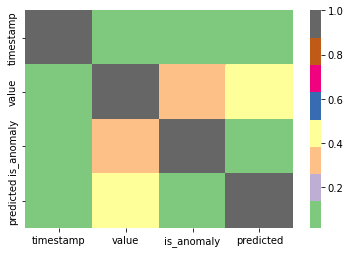

In [ ]:
sns.heatmap(corr, 
            xticklabels=df_train.corr().columns.values,
            yticklabels=df_train.corr().columns.values,
            cmap='Accent'
           )

In [ ]:
print(df_train['is_anomaly'])

0        0
1        0
2        0
3        0
4        0
        ..
15825    0
15826    0
15827    0
15828    0
15829    0
Name: is_anomaly, Length: 15830, dtype: int64


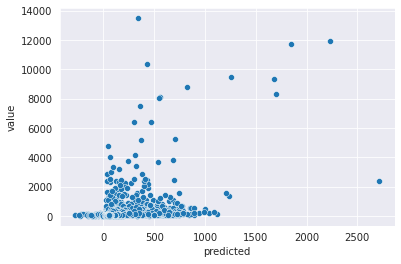

In [ ]:
sns.set_style("darkgrid")
sns.scatterplot(x=df_train['predicted'], y=df_train['value'])

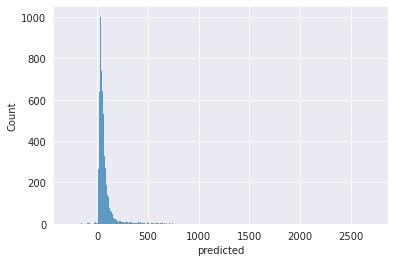

In [ ]:
sns.histplot(x='predicted',data=df_train)

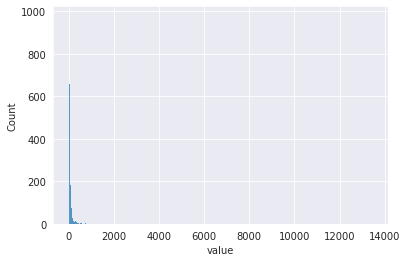

In [ ]:
sns.histplot(x='value',data=df_train)

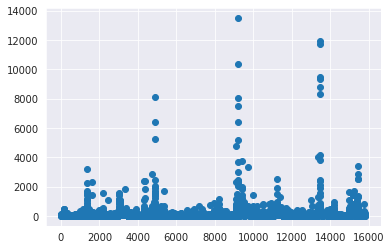

In [ ]:
plt.scatter(range(15830),df_train['value'])

In [ ]:
#Determine the number of anomalous transactions in the dataset

print("Total No of Transactions:",len(df_train))

Fraud = df_train[df_train['is_anomaly']==True]
print("No of Anomalous Transactions:",len(Fraud))

Valid = df_train[df_train['is_anomaly']==False]
print("No of Valid Transactions:",len(Valid))

outlier_fraction = len(Fraud)/float(len(df_train))
valid_fraction = len(Valid)/float(len(df_train))
print("Percentage of Anomalous Transactions:",round((outlier_fraction*100),3))
print("Percentage of Valid Transactions:",round((valid_fraction*100),3))

Total No of Transactions: 15830
No of Anomalous Transactions: 776
No of Valid Transactions: 15054
Percentage of Anomalous Transactions: 4.902
Percentage of Valid Transactions: 95.098


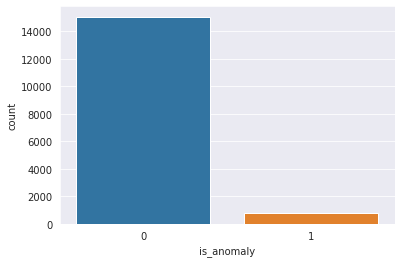

In [ ]:
sns.countplot(x='is_anomaly',data=df_train)

In [ ]:
df_train['is_anomaly'].value_counts()

0    15054
1      776
Name: is_anomaly, dtype: int64

In [ ]:
X_train = df_train.drop(columns=['is_anomaly'],inplace=False,axis=1)
print(X_train)

        timestamp  value  predicted
0      1425008573     42  44.072500
1      1425008873     41  50.709390
2      1425009173     41  81.405120
3      1425009473     61  39.950367
4      1425009773     44  35.350160
...           ...    ...        ...
15825  1429756073     44  53.624115
15826  1429756373     45  59.752296
15827  1429756673     48  52.147630
15828  1429756973     26  58.007545
15829  1429757273     38  59.144700

[15830 rows x 3 columns]


In [ ]:
y_train=df_train['is_anomaly']
print(y_train)

0        0
1        0
2        0
3        0
4        0
        ..
15825    0
15826    0
15827    0
15828    0
15829    0
Name: is_anomaly, Length: 15830, dtype: int64


In [ ]:
print(X_train.shape)
print(y_train.shape)

(15830, 3)
(15830,)


In [ ]:
# Define a random state 
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X_train.shape[0], X_train.shape[1]))

In [ ]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X_train), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',novelty=False,
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Novelty Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',novelty=True,
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1),
    "XGBClassifier":XGBClassifier(learning_rate=1, n_estimators=1300,eta = 0.7, max_depth= 3,  objective= 'multi:softprob',  num_class= 3)
}

In [ ]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    elif clf_name == "Novelty Local Outlier Factor":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
        scores_prediction = clf.negative_outlier_factor_  
    elif clf_name == "XGBClassifier":
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_train)
    else:    
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_train,y_pred))
    print("Classification Report :")
    print(classification_report(y_train,y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 1026
Accuracy Score :
0.9351863550221099
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     15054
           1       0.34      0.34      0.34       776

    accuracy                           0.94     15830
   macro avg       0.65      0.65      0.65     15830
weighted avg       0.94      0.94      0.94     15830

Confusion Matrix:
[[14541   513]
 [  513   263]]
Local Outlier Factor: 1244
Accuracy Score :
0.9214150347441566
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15054
           1       0.20      0.20      0.20       776

    accuracy                           0.92     15830
   macro avg       0.58      0.58      0.58     15830
weighted avg       0.92      0.92      0.92     15830

Confusion Matrix:
[[14432   622]
 [  622   154]]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Novelty Local Outlier Factor: 1139
Accuracy Score :
0.928048010107391
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     15054
           1       0.22      0.18      0.20       776

    accuracy                           0.93     15830
   macro avg       0.59      0.58      0.58     15830
weighted avg       0.92      0.93      0.92     15830

Confusion Matrix:
[[14548   506]
 [  633   143]]
Support Vector Machine: 12204
Accuracy Score :
0.22905874921036007
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.20      0.33     15054
           1       0.05      0.80      0.09       776

    accuracy                           0.23     15830
   macro avg       0.50      0.50      0.21     15830
weighted avg       0.91      0.23      0.32     15830

Confusion Matrix:
[[ 3008 12046]
 [  158   618]]
XGBClassifier: 776
Accuracy Score :
0.9509791535060013
Classifi

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_test=pd.read_csv( path +'test (1).csv')

In [ ]:
df_test.head()

,timestamp,value,predicted
0,1396332000,20.0,20.0
1,1396332300,20.0,20.0
2,1396332600,20.0,20.0
3,1396332900,20.0,20.0
4,1396333200,20.0,20.0


In [ ]:
df_test.describe()

,timestamp,value,predicted
count,3.960000e+03,3960.000000,3960.000000
mean,1.396926e+09,42.909050,43.841335
std,3.429894e+05,28.040740,28.315249
min,1.396332e+09,20.000000,3.158210
25%,1.396629e+09,20.000000,20.037745
50%,1.396926e+09,20.480000,22.011872
75%,1.397223e+09,79.904000,79.077084
max,1.397520e+09,79.999969,114.857970


In [ ]:
X_test = df_test
print(X_test)

       timestamp     value  predicted
0     1396332000  20.00000  20.000000
1     1396332300  20.00000  20.000000
2     1396332600  20.00000  20.000000
3     1396332900  20.00000  20.000000
4     1396333200  20.00000  20.000000
...          ...       ...        ...
3955  1397518500  20.00384  19.836240
3956  1397518800  20.00384  19.207998
3957  1397519100  20.00384  20.103437
3958  1397519400  20.00384  19.346764
3959  1397519700  20.00384  20.134947

[3960 rows x 3 columns]


In [ ]:
# Define a random state 
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X_test.shape[0], X_test.shape[1]))

In [ ]:
print(X_test.shape)

(3960, 3)


In [ ]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
X_test['value']

0       20.00000
1       20.00000
2       20.00000
3       20.00000
4       20.00000
          ...   
3955    20.00384
3956    20.00384
3957    20.00384
3958    20.00384
3959    20.00384
Name: value, Length: 3960, dtype: float64

In [ ]:
clf = XGBClassifier(learning_rate=1, n_estimators=1300,eta = 0.7, max_depth= 3,  objective= 'multi:softprob',  num_class= 3)
clf.fit(X_train,y_train)

XGBClassifier(eta=0.7, learning_rate=1, n_estimators=1300, num_class=3,
              objective='multi:softprob')

In [ ]:
y_test_pred = clf.predict(X_test)

In [ ]:
data={"timestamp":[],"is_anomaly":[]}
for id,pred in zip(df_test["timestamp"].unique(),y_test_pred):
  data["timestamp"].append(id)
  data["is_anomaly"].append(pred)

In [ ]:
output=pd.DataFrame(data,columns=["timestamp","is_anomaly"])
output

,timestamp,is_anomaly
0,1396332000,0
1,1396332300,0
2,1396332600,0
3,1396332900,0
4,1396333200,0
...,...,...
3955,1397518500,0
3956,1397518800,0
3957,1397519100,0
3958,1397519400,0


In [ ]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output['is_anomaly'].value_counts()

Your submission was successfully saved!


0    3949
1      11
Name: is_anomaly, dtype: int64

In [ ]:
train = pd.read_csv( path +'train (1).csv')

In [ ]:
test = pd.read_csv( path +'test (1).csv')

In [ ]:
x= train.drop(['is_anomaly','timestamp'], axis=1)
y= train['is_anomaly']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=103)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=25)

In [ ]:
knn.score(x_test,y_test)

0.9754556939180653

The following Algorithms were used on the dataset for detecting anomalise. KNN, Isolation Forest Classifier, Local Outlier Factor, Novelty local outlier Factor, Support Vector Machine and XGB Classifier.
summary of the result by accuracy. Support Vecto Machine 23%, Local Outlier Factor 92%, Novelty local Outlier Factor 92%, Isolation Forest 93.5%, XGB Classifier 95%, K-NN 98%. KNN having scored the highest accuracy is hereby, considered as the best Model to be build on the datase.t  